# Flipkart GRiD Challenge - Level 2
Flipkart Object Localization Challenge consists of developing a model that localizes (identifies the bounding box) the object in an image. Simply put, given an image, the model should produce coordinates of the rectangle where in the object lies.

## Requirements
- Python 3.5
- Tensorflow 1.12+
- Keras 2.2.0+
- CUDA (recommended version >= 8.0)
- OpenCV
- Python Image Library(PIL)
- Numpy
- Pandas
- MatPlotLib





## Data Analysis and Visualizations

Let's start by importing some libraries to help us explore data.

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance

plt.rcParams['figure.dpi'] = 150

So, we are provided with two CSV files, `training.csv` and `test.csv`. The training file contain image names and coordinates for the bounding boxes. And the test files contains image names for which prediction needs to be done.

Let's start by loading training and testing data:

In [2]:
trainingData = pd.read_csv('training.csv')
print('Training Data Info: \n')
print(trainingData.info())
trainingData.head()

Training Data Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 5 columns):
image_name    14000 non-null object
x1            14000 non-null int64
x2            14000 non-null int64
y1            14000 non-null int64
y2            14000 non-null int64
dtypes: int64(4), object(1)
memory usage: 547.0+ KB
None


,image_name,x1,x2,y1,y2
0,JPEG_20160706_121146_1000145715002.png,115,495,143,325
1,JPEG_20161119_174038_1000690577600.png,23,457,61,409
2,147444927651111470309333776-Roadster-Men-Casua...,37,601,13,470
3,147772332675720161028_161611.png,27,602,162,385
4,1473315333651DeeplearnS11638.png,60,586,174,325


In [3]:
testingData = pd.read_csv('test.csv')
print('Testing Data Info: \n')
print(testingData.info())
testingData.head()

Testing Data Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12815 entries, 0 to 12814
Data columns (total 5 columns):
image_name    12815 non-null object
x1            0 non-null float64
x2            0 non-null float64
y1            0 non-null float64
y2            0 non-null float64
dtypes: float64(4), object(1)
memory usage: 500.7+ KB
None


,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,NaN,NaN,NaN,NaN
1,1473231475010DeeplearnS11276.png,NaN,NaN,NaN,NaN
2,JPEG_20161205_135307_1000155917326.png,NaN,NaN,NaN,NaN
3,JPEG_20160711_123440_1000518778437.png,NaN,NaN,NaN,NaN
4,JPEG_20160803_115329_100034020722.png,NaN,NaN,NaN,NaN


Let's also visualize the image and the bounding box by OpenCV. The images are in the directory `images`.

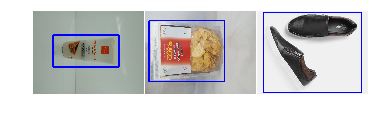

In [4]:
DATA_DIR = 'images/' #set location of the images folder

for i in range(3):
    tr_row = trainingData.loc[i]
    img = cv2.imread(DATA_DIR + tr_row['image_name'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (tr_row['x1'], tr_row['y1']), (tr_row['x2'], tr_row['y2']), (0,0,255), 5)
    plt.subplot(1, 3, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.subplots_adjust(wspace=0.01, hspace=0)
plt.show()

We observe that the data contains images with a single object that we need to localize. The images are representative of Flipkart product offerings from multiple sellers. 

## Evaluation Criteria

The challenge was being evaluated on the metric Mean Intersection over Union(IoU). It is basically, the intersection divided by the union of the true bounding box and the predicted bounding box from the model.

Thus we need to validate our data before evaluation on the actual test set, so let's go ahead and split our data into two sets, one for training and one for validation.

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(trainingData, test_size=0.05, random_state=321)

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

train.to_csv('train.csv', index=False)
test.to_csv('validation.csv', index=False)

TRAIN_CSV = "train.csv"
VALIDATION_CSV = "validation.csv"

Also let's define a function to calculate the IoU from the prediction so that we can monitor it while training.

In [6]:
def IOU(y_true, y_pred):
    diff_width = K.minimum(y_true[:,0] + y_true[:,2], y_pred[:,0] + y_pred[:,2]) - K.maximum(y_true[:,0], y_pred[:,0])
    diff_height = K.minimum(y_true[:,1] + y_true[:,3], y_pred[:,1] + y_pred[:,3]) - K.maximum(y_true[:,1], y_pred[:,1])
    intersection = K.maximum(diff_width, 0) * K.maximum(diff_height, 0)

    area_gt = y_true[:,2] * y_true[:,3]
    area_pred = y_pred[:,2] * y_pred[:,3]
    union = K.maximum(area_gt + area_pred - intersection, 0)

    #ntersection = K.sum(intersection * (union > 0))
    intersection = K.tf.where(union > 0, intersection, K.zeros_like(intersection))
    intersection = K.sum(intersection)
    union = K.sum(union)
    iou = (intersection / (union + epsilon()))
    return iou

# Our Approach

Since, we were required to localize the objects, we tried multiple model and techniques for object detection and finally ensembled the predictions from each model to improve them. We only mention the best approaches which finally were used in ensemble. You can refer at the end, the results and inferences from other models.

Since we have used tensorflow and keras for the challenge, let's import all necessary modules at the very start and declare some global variables.

In [7]:
import math
from keras import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import *
from keras.utils import Sequence
from keras.backend import epsilon
import keras.backend as K
from keras.optimizers import Adam
from keras.regularizers import l2

ALPHA = 0.75

IMAGE_SIZE = 224

EPOCHS = 500
BATCH_SIZE = 32
PATIENCE = 50

MULTI_PROCESSING = True
THREADS = 20

Using TensorFlow backend.



## 1. Imagenet Architectures 

Since the task just involved localization and not classification of objects in the images, a CNN model with regression output would do. We chose imagenet architectures and modified the top layer to give us the regression output.

We tested on multiple architechures and looked at their overall depth, and found out that MobileNetV2(low depth) and InceptionResnetV2(high depth) performed the best amongst comparble depth models. We further added DenseNet121(low depth) to improve the ensemble predictions.

###  Image Preprocessing

Imagenet architechures generally intake square images of fixed shape, thus the current images need to be preprocessed before feeding them to the model. Keras applications containing the pre-built model such MobileNet contains a function `preprocess_input` that preprocesses the images according to requirements. Thus preprocessing is handled by the function itself.

### Data Augmentation

Since, we notice above that the training data contains 14,000 entries and predictions needs to be done on 12,815 entries thus we can say that the training and testing data are almost comparable in size, which might lead to bad model preformance. Thus data augmentation is necessary in our case, so that the model can generalize well.

We did mulitple transforms to the original data, as listed below:
- Rescaling
- Rotation and Flipping
- Croping
- Color and Other Image Enhancements

Also that the dataset being huge, it can't be loaded directly into the memory, so we plan to use the `fit_generator` method in keras to load images on the go from a data generator.

Since we are using data generator, we implemented augmentation within the generator, as done below.



In [8]:
class DataGenerator(Sequence):

    def __init__(self, csv_file,rnd_rescale=True, rnd_multiply=True, rnd_color=True, rnd_crop=True, rnd_flip=True,
                 batch_size = BATCH_SIZE, rnd_dice=True):
        self.paths = []
        self.coords = []
        self.batch_size = batch_size
        self.rnd_rescale = rnd_rescale
        self.rnd_multiply = rnd_multiply
        self.rnd_color = rnd_color
        self.rnd_crop = rnd_crop
        self.rnd_flip = rnd_flip
        self.rnd_dice = rnd_dice

        with open(csv_file, "r") as file:
            self.coords = np.zeros((sum(1 for line in file)-1, 4))
            
        df = pd.read_csv(csv_file)

        for index, row in df.iterrows():
            path = os.path.join(DATA_DIR, row['image_name'])
            x1 = row['x1']
            x2 = row['x2']
            y1 = row['y1']
            y2 = row['y2']

            img = Image.open(path)
            width, height = img.size

            self.coords[index, 0] = x1
            self.coords[index, 1] = y1
            self.coords[index, 2] = x2 
            self.coords[index, 3] = y2 

            self.paths.append(path)
        
    def __len__(self):
        return math.ceil(len(self.coords)*2 / self.batch_size)
      
    def random_rescale(self, img, coords, low = 0.6, high = 1.4):
      img_width = img.width
      img_height = img.height
      scale_ratio = np.random.uniform(low = low, high = high)
      new_width, new_height = int(img_width*scale_ratio), int(img_height*scale_ratio)
      img = img.resize((new_width, new_height))
      x0, y0, x1, y1 = coords
      x0 = x0*new_width/img_width
      y0 = y0*new_height/img_height
      x1 = x1*new_width/img_width
      y1 = y1*new_height/img_height
      
      return img, x0, y0, x1, y1
    
    def random_crop(self, img, coords, crop_ratio = 0.15):
      img_width, img_height = img.width, img.height
      new_x0 = np.random.randint(low = 0, high = int(crop_ratio*img_width))
      new_y0 = np.random.randint(low = 0, high = int(crop_ratio*img_height))
      
      new_x1 = img_width - np.random.randint(low = 0, high = int(crop_ratio*img_width))
      new_y1 = img_height - np.random.randint(low = 0, high = int(crop_ratio*img_height))
      
      img = img.crop((new_x0, new_y0, new_x1, new_y1))
      
      x0, y0, x1, y1 = coords
      x0 = max(x0 - new_x0, 0)
      y0 = max(y0 - new_y0, 0)
      x1 = min(x1 - new_x0, img_width)
      y1 = min(y1 - new_y0, img_height)
      return img, x0, y0, x1, y1
    
    def random_flip(self, img, coords):
      img_width, img_height = img.width, img.height
      x0, y0, x1, y1 = coords
      '''
      Flip types: [0, 90, 180, 270, 1423, 1234]
      0: 0 degree rotation (no change in original image)
      90: 90 degree rotation 
      180: 180 degree rotation
      270: 270 degree rotation
      1423: Top bottom flip (mirror image over a horizontal line passing through the center)
      1234: Left right flip (mirrot image over a vertical line passing though the center)
      '''
      
      #Choosing what type of flip to perform randomly
      flip_type = np.random.choice([0, 90, 180, 270, 1423, 1234])
      if flip_type in [0, 90, 180, 270]:
        
        x = x0 - img_width / 2
        y = y0 - img_height / 2

        x0 = img_width / 2 + x * np.cos(np.deg2rad(flip_type)) - y * np.sin(np.deg2rad(flip_type))
        y0 = img_height / 2 + x * np.sin(np.deg2rad(flip_type)) + y * np.cos(np.deg2rad(flip_type))

        x = x1 - img_width / 2
        y = y1 - img_height / 2

        x1 = img_width / 2 + x * np.cos(np.deg2rad(flip_type)) - y * np.sin(np.deg2rad(flip_type))
        y1 = img_height / 2 + x * np.sin(np.deg2rad(flip_type)) + y * np.cos(np.deg2rad(flip_type))
        
      else:
        
        if flip_type == 1423:
            img = img.transpose(Image.FLIP_TOP_BOTTOM)
            y0 = img_height - y0
            y1 = img_height - y1

        elif flip_type == 1234:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            x0 = img_width - x0
            x1 = img_width - x1
              
      return img, x0, y0, x1, y1
    
    
    def random_color(self, img):
      color_enhancer = ImageEnhance.Color(img)
      img = color_enhancer.enhance(np.random.uniform(low=0.5, high=1.5))

      brightness_enhancer = ImageEnhance.Brightness(img)
      img = brightness_enhancer.enhance(np.random.uniform(low=0.7, high=1.3))
      return img
    
    def random_multiply(self, img, low = 0.8, high = 1.2):
      img[...,0] = np.floor(np.clip(img[...,0] * np.random.uniform(low=low, high=high), 0.0, 255.0))
      img[...,1] = np.floor(np.clip(img[...,1] * np.random.uniform(low=low, high=high), 0.0, 255.0))
      img[...,2] = np.floor(np.clip(img[...,2] * np.random.uniform(low=low, high=high), 0.0, 255.0))     
      return img
    
        

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size//2:(idx + 1) * self.batch_size//2]
        coords = self.coords[idx * self.batch_size//2:(idx + 1) * self.batch_size//2].copy()
        batch_coords = np.zeros((self.batch_size,4))
        batch_images = np.zeros((self.batch_size, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        i = 0
        for j, f in enumerate(batch_paths):
            img = Image.open(f)
            x0,y0,x1,y1 = coords[j]
            image_width = img.width
            image_height = img.height
            img2 = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img2 = img2.convert('RGB')
            img2 = np.array(img2, dtype=np.float32)
            batch_images[i] = preprocess_input(img2.copy())
            
            batch_coords[i, 0] = x0 * IMAGE_SIZE / image_width
            batch_coords[i, 1] = y0 * IMAGE_SIZE / image_height
            batch_coords[i, 2] = (x1 - x0) * IMAGE_SIZE / image_width
            batch_coords[i, 3] = (y1 - y0) * IMAGE_SIZE / image_height 
            
            if self.rnd_dice:
                
                select = np.random.randint(5)
                
                if select==0 and self.rnd_rescale:
                    img, x0, y0, x1, y1 = self.random_rescale(img, [x0, y0, x1, y1])
                    

                if select==1 and self.rnd_crop:
           
                    img, x0, y0, x1, y1 = self.random_crop(img, [x0, y0, x1, y1])
                    
                if select==2 and self.rnd_flip:
                    img, x0, y0, x1, y1 = self.random_flip(img, [x0, y0, x1, y1])

                image_width, image_height = img.width, img.height

                tmp = x0
                x0 = min(x0, x1)
                x1 = max(tmp, x1)

                tmp = y0
                y0 = min(y0, y1)
                y1 = max(tmp, y1)

                x0 = max(x0, 0)
                y0 = max(y0, 0)

                y0 = min(y0, image_height)
                x0 = min(x0, image_width)
                y1 = min(y1, image_height)
                x1 = min(x1, image_width)

                if select==3 and self.rnd_color:
                    
                    img = self.random_color(img)

                img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
                img = img.convert('RGB')
                pil_img = img
                img = np.array(img, dtype=np.float32)
                pil_img.close()
                
                if select==4 and self.rnd_multiply:

                    img = self.random_multiply(img)
                    
                batch_images[i+1] = preprocess_input(img.copy())

                batch_coords[i+1, 0] = x0 * IMAGE_SIZE / image_width
                batch_coords[i+1, 1] = y0 * IMAGE_SIZE / image_height
                batch_coords[i+1, 2] = (x1 - x0) * IMAGE_SIZE / image_width
                batch_coords[i+1, 3] = (y1 - y0) * IMAGE_SIZE / image_height 
                
            i+=2
            
        return batch_images, batch_coords


### Loading Validation Data into the Memory

Unlike training data validation can still be performed via loading data into memory, and will help improve training time. Also, as we are not doing any augmentation in the validation data we can save some time by defining another data generator just for validation purpose.

In [9]:
from keras.applications.imagenet_utils import preprocess_input

valData = pd.read_csv('validation.csv')

val_coords = np.zeros((len(valData),4))
val_images = np.zeros((len(valData), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for index, row in valData.iterrows():
    path = os.path.join(DATA_DIR, row['image_name'])
    x1 = row['x1']
    x2 = row['x2']
    y1 = row['y1']
    y2 = row['y2']

    img = Image.open(path)
    width, height = img.size

    val_coords[index, 0] = x1*IMAGE_SIZE / width
    val_coords[index, 1] = y1*IMAGE_SIZE / height
    val_coords[index, 2] = (x2 - x1)* IMAGE_SIZE / width
    val_coords[index, 3] = (y2 - y1)*IMAGE_SIZE / height 
    
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = img.convert('RGB')
    pil_img = img
    img = np.array(img, dtype=np.float32)
    val_images[index] = preprocess_input(img.copy())
    pil_img.close()

class ValDataGenerator(Sequence):
    def __init__(self, val_images, val_coords, batch_size = BATCH_SIZE):
        self.images = val_images
        self.coords = val_coords
        self.batch_size = batch_size
        
    def __len__(self):
        return math.ceil(len(self.coords) / self.batch_size)
    
    def __getitem__(self, idx):
        batch_coords = self.coords[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_images, batch_coords


### 1.1 MobileNetV2

Please see the notebook, `Flipkart_MobileNetV2.ipynb` for this model.

### 1.2 InceptionResnetV2

Please see the notebook, `Flipkart_InceptionResnetV2.ipynb` for this model.


### 1.1 DenseNet121

Please see the notebook, `Flipkart_DenseNet121.ipynb` for this model.

## 2. U-Net based Approach

Please see the notebook, `Flipkart_UNet.ipynb` for this model.

## Ensemble Model

Since we created three models, the best bounding box prediction can be obtained from creating an ensemble. Rather than creating one big ensemble model and training, we used the predictions from each model to again train a sparse network to get the ensembled prediction, mainly because we were limited in memory.

So let's start by loading the predicted and true data for both training and test sets.

In [20]:
mnv2_train = pd.read_csv('mnv2-training.csv')
irv2_train = pd.read_csv('irv2-training.csv')
unet_train = pd.read_csv('unet-training.csv')
dn121_train = pd.read_csv('dn121-training.csv')

mnv2_prediction = pd.read_csv('mnv2-prediction.csv')
irv2_prediction = pd.read_csv('irv2-prediction.csv')
unet_prediction = pd.read_csv('unet-prediction.csv')
dn121_prediction = pd.read_csv('dn121-prediction.csv')

true_train = pd.read_csv('training.csv')

Now let's combine the train and test dataframes to get a final ensemble dataframe to train on.

In [21]:
train_df = mnv2_train.copy()
irv2_train.drop(['image_name'], axis=1, inplace=True)
dn121_train.drop(['image_name'], axis=1, inplace=True)
unet_train.drop(['image_name'], axis=1, inplace=True)
cols = unet_train.columns
unet_train[cols] = unet_train[cols].astype('float')
true_train.drop(['image_name'], axis=1, inplace=True)
cols = true_train.columns
true_train[cols] = true_train[cols].astype('float')

train_df = pd.concat([train_df, irv2_train, dn121_train, unet_train, true_train], axis=1, sort=False)
train_df.head()

,image_name,x1,x2,y1,y2,x1,x2,y1,y2,x1,...,y1,y2,x1,x2,y1,y2,x1,x2,y1,y2
0,JPEG_20160706_121146_1000145715002.png,116.488691,479.667097,137.030443,320.486494,112.623140,486.479639,143.944880,322.386879,108.527723,...,141.750330,328.987296,212.0,442.0,185.0,262.0,115.0,495.0,143.0,325.0
1,JPEG_20161119_174038_1000690577600.png,19.543638,456.589791,50.167588,411.500244,18.872901,458.645812,56.914948,409.820708,24.628683,...,60.318763,410.970415,97.0,439.0,90.0,381.0,23.0,457.0,61.0,409.0
2,147444927651111470309333776-Roadster-Men-Casua...,44.351245,581.978542,14.793642,467.495335,33.014124,584.838328,14.506661,474.367210,32.016806,...,14.669755,458.516137,81.0,581.0,17.0,446.0,37.0,601.0,13.0,470.0
3,147772332675720161028_161611.png,23.505922,600.007368,162.537231,384.263567,26.088606,599.741129,160.039642,376.533922,25.999780,...,162.159789,382.638441,30.0,603.0,175.0,377.0,27.0,602.0,162.0,385.0
4,1473315333651DeeplearnS11638.png,60.573774,589.376787,170.065073,327.469679,63.644652,586.397040,172.365763,329.395225,63.780997,...,174.768857,328.233686,64.0,583.0,186.0,325.0,60.0,586.0,174.0,325.0


In [22]:
prediction_df = mnv2_prediction.copy()
irv2_prediction.drop('image_name', axis=1, inplace=True)
dn121_prediction.drop('image_name', axis=1, inplace=True)
unet_prediction.drop('image_name', axis=1, inplace=True)
unet_prediction[cols] = unet_prediction[cols].astype('float')

prediction_df = pd.concat([prediction_df, irv2_prediction, dn121_prediction, unet_prediction], axis=1, sort=False)
prediction_df.head()

,image_name,x1,x2,y1,y2,x1,x2,y1,y2,x1,x2,y1,y2,x1,x2,y1,y2
0,1474723840903DSC08089.png,232.980238,445.972334,87.559384,406.391929,235.094978,440.136588,85.0,407.264972,235.939549,442.816642,88.411151,405.971048,244.0,440.0,95.0,405.0
1,1473231475010DeeplearnS11276.png,79.201922,575.766427,139.864802,353.357588,77.301879,571.115045,136.0,349.207898,80.780334,571.631513,140.321029,346.283242,88.0,567.0,153.0,348.0
2,JPEG_20161205_135307_1000155917326.png,140.767855,499.899641,54.468907,439.924066,143.755716,495.905231,51.0,434.858856,139.760808,495.100098,51.288851,432.249690,158.0,491.0,56.0,435.0
3,JPEG_20160711_123440_1000518778437.png,221.316071,461.600516,88.184885,420.183040,212.827932,464.292923,92.0,415.366831,210.035313,468.081621,92.802388,420.413164,262.0,432.0,131.0,402.0
4,JPEG_20160803_115329_100034020722.png,124.407174,501.422250,42.546689,441.118862,140.062954,503.236178,42.0,429.725828,40.428072,477.029550,44.277841,435.884498,150.0,496.0,43.0,430.0


Now building the ensemble model.

In [23]:

x1a = Input(shape=(1,)) 
x2a = Input(shape=(1,))
y1a = Input(shape=(1,))
y2a = Input(shape=(1,))
x1b = Input(shape=(1,))
x2b = Input(shape=(1,))
y1b = Input(shape=(1,))
y2b = Input(shape=(1,))
x1c = Input(shape=(1,))
x2c = Input(shape=(1,))
y1c = Input(shape=(1,))
y2c = Input(shape=(1,))
x1d = Input(shape=(1,))
x2d = Input(shape=(1,))
y1d = Input(shape=(1,))
y2d = Input(shape=(1,))

x1 = Concatenate()([x1a, x1b, x1c, x1d])
x2 = Concatenate()([x2a, x2b, x2c, x2d])
y1 = Concatenate()([y1a, y1b, y1c, y1d])
y2 = Concatenate()([y2a, y2b, y2c, y2d])

x1 = Dense(1)(x1)
x2 = Dense(1)(x2)
y1 = Dense(1)(y1)
y2 = Dense(1)(y2)

ensemble = Model(inputs=[x1a, x2a, y1a, y2a, x1b, x2b, y1b, y2b, x1c, x2c, y1c, y2c, x1d, x2d, y1d, y2d], outputs=[x1,x2,y1,y2])

ensemble.summary()

ensemble.compile(loss="mean_absolute_error", optimizer="adam")



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_18 (

Now let's go ahead and compile our model and then train it.

In [35]:
ensemble.compile(loss="mean_absolute_error", optimizer="adam")

stop = EarlyStopping(monitor="loss", patience=3, mode="min")

ensemble.fit(np.transpose(train_df.iloc[:,1:17].values).tolist(), np.transpose(train_df.iloc[:,17:].values).tolist(), epochs=100, callbacks=[stop])

Epoch 1/100
14000/14000 [==============================] - 4s 268us/step - loss: 16.8368 - dense_5_loss: 3.9484 - dense_6_loss: 4.7565 - dense_7_loss: 3.7679 - dense_8_loss: 4.3640
Epoch 2/100
14000/14000 [==============================] - 3s 225us/step - loss: 16.8026 - dense_5_loss: 3.9542 - dense_6_loss: 4.7709 - dense_7_loss: 3.7593 - dense_8_loss: 4.3183
Epoch 3/100
14000/14000 [==============================] - 3s 229us/step - loss: 16.7930 - dense_5_loss: 3.9515 - dense_6_loss: 4.7656 - dense_7_loss: 3.7569 - dense_8_loss: 4.3190
Epoch 4/100
14000/14000 [==============================] - 3s 230us/step - loss: 16.7856 - dense_5_loss: 3.9360 - dense_6_loss: 4.7627 - dense_7_loss: 3.7575 - dense_8_loss: 4.3294
Epoch 5/100
14000/14000 [==============================] - 3s 233us/step - loss: 16.7700 - dense_5_loss: 3.9381 - dense_6_loss: 4.7647 - dense_7_loss: 3.7507 - dense_8_loss: 4.3165
Epoch 6/100
14000/14000 [==============================] - 3s 228us/step - loss: 16.7843 - dens

Finally save the weights for our ensemble.

In [25]:
## Since the models will take a huge amount of time to train, you can download the trained weights from 
## this Google Drive folder into the directory
## https://drive.google.com/drive/folders/1rOVkxqHaCKjamji7c3XfdomvMbqksgU6?usp=sharing

ensemble.save_weights("ensemble_weights.h5", overwrite=True)

Making the predictions on the prediction dataframe.

In [36]:
preds = pd.DataFrame.from_records(ensemble.predict(np.transpose(prediction_df.iloc[:,1:17].values).tolist()))
preds = preds.T
preds.head()

,0,1,2,3
0,[235.63202],[441.83658],[87.590195],[406.0967]
1,[79.51423],[571.82227],[139.54645],[347.32394]
2,[143.05956],[496.3925],[52.99826],[432.98874]
3,[215.46329],[463.141],[91.70619],[417.69034]
4,[115.71315],[498.44455],[43.3562],[432.7257]


In [37]:
test = pd.read_csv("test.csv")
test.head()

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,NaN,NaN,NaN,NaN
1,1473231475010DeeplearnS11276.png,NaN,NaN,NaN,NaN
2,JPEG_20161205_135307_1000155917326.png,NaN,NaN,NaN,NaN
3,JPEG_20160711_123440_1000518778437.png,NaN,NaN,NaN,NaN
4,JPEG_20160803_115329_100034020722.png,NaN,NaN,NaN,NaN


In [38]:
for index, row in preds.iterrows():

    test.iloc[index,1] = np.asscalar(row[0])
    test.iloc[index,2] = np.asscalar(row[1])
    test.iloc[index,3] = np.asscalar(row[2])
    test.iloc[index,4] = np.asscalar(row[3])

test.head()

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,235.632019,441.836578,87.590195,406.096710
1,1473231475010DeeplearnS11276.png,79.514229,571.822266,139.546448,347.323944
2,JPEG_20161205_135307_1000155917326.png,143.059555,496.392487,52.998260,432.988739
3,JPEG_20160711_123440_1000518778437.png,215.463287,463.140991,91.706192,417.690338
4,JPEG_20160803_115329_100034020722.png,115.713150,498.444550,43.356201,432.725708


In [39]:
test.to_csv('ensemble-prediction.csv', index=False)

Upon uploading the predictions online to the competition, we achieved a Mean IoU score of 0.92+ with the ensemble model. Details and results on various models are discussed below.

# Results

Though we showed only three different architectures to achieve better predictions, we tested on a large number of models and used a number of techniques. We will here discuss our inferences throughout the challenge and why we chose the models we did.

Let's look at some of our predictions first.

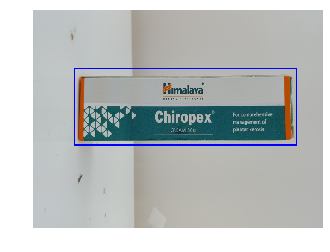

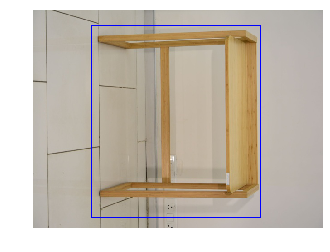

In [11]:
preds = pd.read_csv('ensemble-prediction.csv')

s = np.random.randint(12000)

for i in range(s, s+2):
    tr_row = preds.loc[i]
    img = cv2.imread(DATA_DIR + tr_row['image_name'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(img, (int(tr_row['x1']), int(tr_row['y1'])), (int(tr_row['x2']), int(tr_row['y2'])), (0,0,255), 2)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

## Current Scores

The following tables shows the scores achieved by the above discussed models on the leaderboard.
```
+-------------------+----------------+
| Model             | Mean IoU Score |
+-------------------+----------------+
| MobileNetV2       | 0.9246         |
+-------------------+----------------+
| DenseNet121       | 0.9225         |
+-------------------+----------------+
| InceptionResnetV2 | 0.9262         |
+-------------------+----------------+
| U-Net             | 0.8803         |
+-------------------+----------------+
| Ensemble          | 0.9306         |
+-------------------+----------------+
```

## Discussion

In this section we discuss why we chose the models discussed above and what alternative approaches we tried.

### Imagenet Architectures

Since the task involved localization of just single object, the current imagenet architectures becomes a normal choice because of their accuracy and ease of implementation. So we decided to modify the top layers of these architectures to get regression output for the coordinates of bounding box.

We decided to use two different models, one with high depth and one with low depth to test what we obtain.

Since multiple competitions were won by both MobileNetV2 and InceptionResnetV2, they became our obvious choice.

**Top Layer:** We tried multiple combinations of top layer including Pooling, BatchNormalization and Fully-Connected Layers but found that the architectures worked best how they were designed and adding Convolutional Layers only helped. A possible reason we found for such outcome is also mentioned in this paper ( arXiv:1412.6806 ).

As expected both models performed well on the data with augmentations, with InceptionResnetV2 performing marginally better than MobileNetV2 because of the depth of the network.

We later added DenseNet121 to improve ensemble predictions as it is comparable in depth with MobileNetV2.

### U-Net

Though this was an object localization challenge but segmentation has had a lot of research and lately pretty good models have emerged for the same.

We wanted to test segmentation out as a side-model, thus we chose U-Net as our model. U-Net is particularly small but pretty effective, which is exactly what we wanted. Other image segmentation models such DeepLabV3+ would have performed better but the overall training time would be huge.

We calculated the bounding box by determining the mask boundaries and then throwing out pixel values from the 640x480 matrix.

Since we couldn't have used other pre built model for getting segmentation mask we used OpenCV and its advanced image operations to get a rough segmentation mask for the objects particularly effective where there was a good contrast in the background and the object. The method was ineffective against transparent/translucent objects and where there was a low contrast between the object and background.

Though we didn't achieve very high Mean IoU score the model gave pretty decent performance given the masks were roughly drawn and we noticed that it performed better than the imagenet models on high contrast images.

Thus we decided to include the model in our ensemble to get a better score overall.

### Other Techniques

Apart from the two already disccused we tried multiple architectures such as YOLOv2, RetinaNet and AttentionNet. We weren't really inclined towards region proposal networks as the task just included localization of the main single object.

These models plateau around ~0.86 Mean IoU score, and didn't help much.

AttentionNet did achieve a good score of ~0.90 combined with our MobileNetV2 as a base model, but we couldn't test it more due to time limitations.

## Future Scope and Conclusions

- Though the models achieved a good score, we felt that not all the images we correctly labeled for bounding boxes, especially images that objects with circular or not sharp edges. We felt if the dataset itself is improved, it will help attain a higher score.
- More models and techniques still remain to be tested for the above task, such as Reinforcement Learning for finding the object and localizing it.
- A bigger ensemble model, with on-the-go training could help improve predictions a lot.
- We suggest using MobileNetV2 for achieving good scores since the model is quick and small, and takes a lot less time compared to any other model, with reasonably accurate predictions.